# Segundo Práctico: Limpieza de datos

Vamos a aplicar el [checklist del Banco Mundial](https://dimewiki.worldbank.org/wiki/Checklist:_Data_Cleaning) en Python usando el [SciPy stack](https://www.scipy.org/stackspec.html), principalmente pandas

## 0. Prerequisitos

Aclaración: La próxima celda es para compatilibidad con Colab, NO ES RECOMENDADO realizar pip install desde un notebook.

In [1]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
  BASE_DIR = "https://github.com/DiploDatos/AnalisisYCuracion/raw/master/"
else:
  BASE_DIR = ".."
if 'ftfy' not in sys.modules:
    !pip install 'ftfy<5.6'

     |████████████████████████████████| 51kB 2.5MB/s 


# 1. Importando los datos

# 1.1. Verificar que no hay problemas en la importación

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format  # para que aparezcan con 2 decimales

Veamos de importar datos de proyectos de Kickstarter la plataforma de Crowdsourcing

In [3]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv")

Veamos los datos cargados en el dataframe

In [4]:
kickstarter_2018

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378656,999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,15000.00,2016-01-13 18:13:53,200.00,failed,6,US,200.00,200.00,15000.00


Por defecto solo vemos los valores al comienzo o al final del archivo.

Tomemos una muestra al azar para ver valores más dispersos

In [5]:
# set seed for reproducibility
import numpy as np
np.random.seed(0)

In [6]:
kickstarter_2018.sample(5)  # trae 5 filas al azar

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
338862,796196901,10G Christmas Tree,Art,Art,USD,2010-12-26,10526.00,2010-12-08 08:44:04,0.00,failed,0,US,0.00,0.00,10526.00
277871,483825010,Gliff,Gaming Hardware,Games,USD,2016-03-28,10000.00,2016-01-28 04:56:18,51.00,failed,5,US,51.00,51.00,10000.00
47000,123916947,STUFFED Food Truck,Food Trucks,Food,USD,2015-01-06,60000.00,2014-11-07 02:24:36,25.00,failed,1,US,25.00,25.00,60000.00
111338,1565733636,NeoExodus Adventure: Origin of Man for Pathfin...,Tabletop Games,Games,USD,2012-05-01,500.00,2012-03-15 01:16:10,585.00,successful,17,US,585.00,585.00,500.00
53743,1273544891,NAPOLEON IN NEW YORK! an original TV Series,Comedy,Film & Video,USD,2016-07-26,25000.00,2016-05-27 00:07:25,25.00,failed,1,US,25.00,25.00,25000.00


No se observa a simple vista ningún problema obvio.

Notar que todos vimos los mismos resultados. Al fijar la semilla no hubo tal azar, esto es algo necesario cuando queremos "reproducir valores aleatorios"

Veamos la descripción del dataset si se corresponde con lo levantado https://www.kaggle.com/kemical/kickstarter-projects/data

In [7]:
pd.DataFrame([["ID", "No description provided", "Numeric"],
["name", "No description provided", "String"],
["category", "No description provided", "String"],
["main_category", "No description provided", "String"],
["currency", "No description provided", "String"],
["deadline", "No description provided", "DateTime"],
["goal", "Goal amount in project currency", "Numeric"],
["launched", "No description provided", "DateTime"],
["pledged", "Pledged amount in the project currency", "Numeric"],
["state", "No description provided", "String"],
["backers", "No description provided", "Numeric"],
["country", "No description provided", "String"],
["usd pledged", "Pledged amount in USD (conversion made by KS)", "Numeric"],
["usd_pledged_real", "Pledged amount in USD (conversion made by fixer.io api)", "Numeric"],
["usd_goal_real", "Goal amount in USD", "Numeric"]], columns=["Field name","Field description", "Type"])

,Field name,Field description,Type
0,ID,No description provided,Numeric
1,name,No description provided,String
2,category,No description provided,String
3,main_category,No description provided,String
4,currency,No description provided,String
5,deadline,No description provided,DateTime
6,goal,Goal amount in project currency,Numeric
7,launched,No description provided,DateTime
8,pledged,Pledged amount in the project currency,Numeric
9,state,No description provided,String


Ahora veamos los **tipos de datos** que detectó pandas

In [8]:
kickstarter_2018.dtypes

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

Los campos object generalmente son String, entonces parece que no reconoció como fechas en **deadline** y **launched** :(

Veamos los datos un resumen de los datos

In [9]:
kickstarter_2018.describe()   # nos brinda un resúmen descriptivo de los datos, tipo summarise en R

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,378661.00,378661.00,378661.00,378661.00,374864.00,378661.00,378661.00
mean,1074731191.99,49080.79,9682.98,105.62,7036.73,9058.92,45454.40
std,619086204.32,1183391.26,95636.01,907.19,78639.75,90973.34,1152950.06
min,5971.00,0.01,0.00,0.00,0.00,0.00,0.01
25%,538263516.00,2000.00,30.00,2.00,16.98,31.00,2000.00
50%,1075275634.00,5200.00,620.00,12.00,394.72,624.33,5500.00
75%,1610148624.00,16000.00,4076.00,56.00,3034.09,4050.00,15500.00
max,2147476221.00,100000000.00,20338986.27,219382.00,20338986.27,20338986.27,166361390.71


Por defecto **se ven los datos numéricos, veamos el resto.**

In [10]:
kickstarter_2018.describe(include=['object'])

,name,category,main_category,currency,deadline,launched,state,country
count,378657,378661,378661,378661,378661,378661,378661,378661
unique,375764,159,15,14,3164,378089,6,23
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,1970-01-01 01:00:00,failed,US
freq,41,22314,63585,295365,705,7,197719,292627


Operemos un cacho sobre los datos de lanzamiento

In [11]:
kickstarter_2018['launched'].min()   # nos devuelve el mínimo valor, es decir, el proyecto con la fecha más antigua de lanzamiento. 

'1970-01-01 01:00:00'

Indiquemos que columnas son fechas como indica la [documentación](https://pandas.pydata.org/pandas-docs/stable/io.html#datetime-handling)

In [12]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"])    # indicamos que ambas columnas son fechas
kickstarter_2018.dtypes

ID                           int64
name                        object
category                    object
main_category               object
currency                    object
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                       object
backers                      int64
country                     object
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

Ahora vemos que esas columnas fueron reconocidas como fechas

Veamos la misma muestra de nuevo

In [13]:
kickstarter_2018.sample(5)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
299667,595962034,Button Poetry Live!,Mixed Media,Art,USD,2015-09-18,10000.00,2015-08-19 19:34:20,18216.27,successful,455,US,18216.27,18216.27,10000.00
181674,1924707671,"C STREET 2012 : Tbilisi, Georgia",World Music,Music,USD,2012-06-07,5000.00,2012-05-08 18:22:59,7210.69,successful,82,US,7210.69,7210.69,5000.00
137583,1698707842,Dérive's Next Project,Punk,Music,USD,2014-07-06,1200.00,2014-06-08 17:58:37,1255.66,successful,33,US,1255.66,1255.66,1200.00
296861,581269566,Photo Book - World Santa Claus Congress,Photobooks,Photography,DKK,2017-04-14,110000.00,2017-03-14 23:45:35,462.00,failed,5,DK,0.00,66.46,15823.47
66362,1337585114,Kickstart CLE Brewing to greatness!,Drinks,Food,USD,2017-08-19,6500.00,2017-07-20 21:22:43,250.00,failed,5,US,75.00,250.00,6500.00


Y veamos el resumen de los datos

In [14]:
kickstarter_2018.describe(include='all')  # ahora en el resúmen se incluyen las fechas 

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,378661.00,378657,378661,378661,378661,378661,378661.00,378661,378661.00,378661,378661.00,378661,374864.00,378661.00,378661.00
unique,nan,375764,159,15,14,3164,nan,378089,nan,6,nan,23,nan,nan,nan
top,nan,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08 00:00:00,nan,1970-01-01 01:00:00,nan,failed,nan,US,nan,nan,nan
freq,nan,41,22314,63585,295365,705,nan,7,nan,197719,nan,292627,nan,nan,nan
first,nan,NaN,NaN,NaN,NaN,2009-05-03 00:00:00,nan,1970-01-01 01:00:00,nan,NaN,nan,NaN,nan,nan,nan
last,nan,NaN,NaN,NaN,NaN,2018-03-03 00:00:00,nan,2018-01-02 15:02:31,nan,NaN,nan,NaN,nan,nan,nan
mean,1074731191.99,NaN,NaN,NaN,NaN,NaN,49080.79,NaN,9682.98,NaN,105.62,NaN,7036.73,9058.92,45454.40
std,619086204.32,NaN,NaN,NaN,NaN,NaN,1183391.26,NaN,95636.01,NaN,907.19,NaN,78639.75,90973.34,1152950.06
min,5971.00,NaN,NaN,NaN,NaN,NaN,0.01,NaN,0.00,NaN,0.00,NaN,0.00,0.00,0.01
25%,538263516.00,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,30.00,NaN,2.00,NaN,16.98,31.00,2000.00


Podemos ver que tenemos primero y último en el resumen de las columnas de fechas.

Ahora deberíamos poder calcular el rango de fechas de lanzamietos

In [15]:
kickstarter_2018['launched'].max() - kickstarter_2018['launched'].min()    #como ambos campos son del tipo fecha ahora si funciona el ejercicio

Timedelta('17533 days 14:02:31')

# 1.2. Asegurar de tener ids/claves únicas

Chequear que no hay datos duplicados

In [16]:
kickstarter_2018.shape   # verifico que no haya duplicados

(378661, 15)

Pandas soporta índices en los DataFrames vamos a recargar el conjunto de datos

In [17]:
kickstarter_2018 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", 
                               parse_dates=["deadline","launched"],
                               index_col=['ID'])

In [18]:
kickstarter_2018

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00
999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00
999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00


In [19]:
kickstarter_2018.shape

(378661, 14)

De esta forma podemos buscar por el índice

In [20]:
kickstarter_2018.loc[999988282]  

name                Nou Renmen Ayiti!  We Love Haiti!
category                              Performance Art
main_category                                     Art
currency                                          USD
deadline                          2011-08-16 00:00:00
goal                                          2000.00
launched                          2011-07-19 09:07:47
pledged                                        524.00
state                                          failed
backers                                            17
country                                            US
usd pledged                                    524.00
usd_pledged_real                               524.00
usd_goal_real                                 2000.00
Name: 999988282, dtype: object

También podemos verificar si hay **filas de contenidos duplicado**

In [21]:
kickstarter_2018[kickstarter_2018.duplicated()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,


Como Pandas **acepta valores duplicados en los índices también debemos verificar ahí**

In [22]:
pd.Series(kickstarter_2018.index,dtype=str).describe()   # verificamos si en los índices no hay duplicados

count         378661
unique        378661
top       1211723636
freq               1
Name: ID, dtype: object

In [23]:
kickstarter_2018[kickstarter_2018.index.duplicated()]

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,


# **Ejercicio 1 para entrega final**

Armar una tabla con todos los proyectos con nombres duplicados, ordenados para revisar agrupados. 

In [28]:
kickstarter_2018[kickstarter_2018.name.duplicated(keep=False)].sort_values('name')

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
816998285,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-02-09,6500.00,2013-12-19 21:51:50,0.00,canceled,0,US,0.00,0.00,6500.00
815783250,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-03-01,6500.00,2014-01-03 20:39:16,37.00,failed,3,US,37.00,37.00,6500.00
1010584633,"""A Fresh Start""",Shorts,Film & Video,USD,2011-09-25,3000.00,2011-08-28 21:27:52,3000.00,successful,24,US,3000.00,3000.00,3000.00
713417995,"""A Fresh Start""",Documentary,Film & Video,USD,2013-03-27,5000.00,2013-01-26 03:51:47,1417.00,failed,26,US,1417.00,1417.00,5000.00
1880084695,"""American Sports Stories"" - An Athletic Quest",Shorts,Film & Video,USD,2015-08-26,100000.00,2015-06-27 02:02:00,100.00,failed,1,US,100.00,100.00,100000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329580179,xxx (Canceled),Art,Art,USD,2011-09-03,10000.00,2011-06-05 04:54:37,1151.00,canceled,18,US,1151.00,1151.00,10000.00
1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.00,2012-01-01 12:35:31,100.00,failed,1,US,100.00,100.00,200000.00
634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.00,2012-12-19 23:57:48,196.00,failed,12,GB,317.73,316.05,3224.97


# 1.3. Despersonalizar datos y guardarlos en un nuevo archivo

Hay muuuchas técnicas para despersonalizar datos.

Para ilustrar mostramos las ofrecidas por Google https://cloud.google.com/dlp/docs/transformations-reference:

* **Reemplazo**: Reemplaza cada valor de entrada con un valor determinado.
* **Ocultamiento**: Quita un valor y lo oculta.
* **Enmascaramiento con caracteres**: Enmascara una string por completo o parcialmente mediante el reemplazo de un número determinado de caracteres con un carácter fijo especificado..
* **Seudonimización mediante el reemplazo de un valor de entrada con un hash criptográfico**: Reemplaza valores de entrada con una string hexadecimal de 32 bytes mediante una clave de encriptación de datos.
* **Cambio de fechas**: Cambia las fechas por un número de días al azar, con la opción de ser coherente en el mismo contexto..
* **Seudonimización mediante el reemplazo con token de preservación de formato criptográfico**: Reemplaza un valor de entrada con un token, o valor sustituto, de la misma longitud mediante la encriptación de preservación de formato (FPE) con el modo de operación FFX. Esto permite que se use el resultado en sistemas con validación de formato o que necesitan aparecer como reales a pesar de que la información no se revela.
* **Valores de depósito con base en rangos de tamaño fijos**: Enmascara los valores de entrada y los reemplaza por depósitos, o rangos dentro de los cuales se encuentra el valor de entrada.
* **Valores de depósito con base en rangos de tamaño personalizados**: Valores de entrada de depósito con base en rangos configurables por el usuario y valores de reemplazo.
* **Extracción de datos de tiempo**: EExtrae o preserva una porción de los valores Date, Timestamp y TimeOfDay.

In [29]:
from hashlib import md5

In [30]:
def hashit(val):
    if isinstance(val, float): 
        return str(val)
    return md5(val.encode('utf-8')).hexdigest()


kickstarter_2018['name'].apply(hashit)

ID
1000002330    a6828ae8a2eca25f0dd7035efc0af0a0
1000003930    81609b3bdc0b96f429672d69702f2524
1000004038    c12f5c3bace2f0213cdb2679a265dca0
1000007540    4dbdcf09c86bbf5683ec39bc57b77f81
1000011046    9c01404a2ef702811c2088ce139042ad
                            ...               
999976400     d89228576343394467096843057f3aa4
999977640     bbcb30bd9bd4f9bff0a96fc44d0001f0
999986353     6c3094666e1a315b6e179566fe3972d9
999987933     887be409ad8b93f26084845a41d4c178
999988282     11f7ae3385c567df409deb5f4ac9a2a5
Name: name, Length: 378661, dtype: object

# **Ejercicio 2 para entrega final**

Verificar que los proyectos que tienen nombres duplicados también tienen el hash de nombre duplicado

In [31]:
repeat = kickstarter_2018[kickstarter_2018.name.duplicated(keep=False)].sort_values('name')
name_hash = repeat['name'].apply(hashit)
print('Dado que los proyectos repetidos estan ordenados podemos ver que los hash son los \
      mismos si los nombres son iguales.')
repeat.merge(name_hash, on='ID')

Dado que los proyectos repetidos estan ordenados podemos ver que los hash son los       mismos si los nombres son iguales.


,name_x,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,name_y
ID,,,,,,,,,,,,,,,
816998285,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-02-09,6500.00,2013-12-19 21:51:50,0.00,canceled,0,US,0.00,0.00,6500.00,0c7a251ffe4c7834cbc4b04906952ff1
815783250,"""...The Last shall be first..."" LODB Lifestyle...",Fashion,Fashion,USD,2014-03-01,6500.00,2014-01-03 20:39:16,37.00,failed,3,US,37.00,37.00,6500.00,0c7a251ffe4c7834cbc4b04906952ff1
1010584633,"""A Fresh Start""",Shorts,Film & Video,USD,2011-09-25,3000.00,2011-08-28 21:27:52,3000.00,successful,24,US,3000.00,3000.00,3000.00,67554ab4203d95f2f2f05365f768206e
713417995,"""A Fresh Start""",Documentary,Film & Video,USD,2013-03-27,5000.00,2013-01-26 03:51:47,1417.00,failed,26,US,1417.00,1417.00,5000.00,67554ab4203d95f2f2f05365f768206e
1880084695,"""American Sports Stories"" - An Athletic Quest",Shorts,Film & Video,USD,2015-08-26,100000.00,2015-06-27 02:02:00,100.00,failed,1,US,100.00,100.00,100000.00,19a82bc4c5961834282575d07d9b5f7c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329580179,xxx (Canceled),Art,Art,USD,2011-09-03,10000.00,2011-06-05 04:54:37,1151.00,canceled,18,US,1151.00,1151.00,10000.00,930857c212f21166427b23d4a7fe52a3
1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.00,2012-01-01 12:35:31,100.00,failed,1,US,100.00,100.00,200000.00,nan
634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.00,2012-12-19 23:57:48,196.00,failed,12,GB,317.73,316.05,3224.97,nan


# 1.4. Nunca modificar los datos crudos u originales


In [32]:
if not in_colab:
  kickstarter_2018.to_csv(BASE_DIR + "/output/ks-projects-201801-for-pandas.csv")


# 2. Pasos necesarios


In [33]:
#import pandas as pd
if not in_colab:
  kickstarter_2018 = pd.read_csv(BASE_DIR + "/output/ks-projects-201801-for-pandas.csv",
                        index_col='ID',
                        parse_dates=['deadline','launched'])

In [34]:
kickstarter_2018.describe(include='all')

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
count,378657,378661,378661,378661,378661,378661.00,378661,378661.00,378661,378661.00,378661,374864.00,378661.00,378661.00
unique,375764,159,15,14,3164,nan,378089,nan,6,nan,23,nan,nan,nan
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08 00:00:00,nan,1970-01-01 01:00:00,nan,failed,nan,US,nan,nan,nan
freq,41,22314,63585,295365,705,nan,7,nan,197719,nan,292627,nan,nan,nan
first,NaN,NaN,NaN,NaN,2009-05-03 00:00:00,nan,1970-01-01 01:00:00,nan,NaN,nan,NaN,nan,nan,nan
last,NaN,NaN,NaN,NaN,2018-03-03 00:00:00,nan,2018-01-02 15:02:31,nan,NaN,nan,NaN,nan,nan,nan
mean,NaN,NaN,NaN,NaN,NaN,49080.79,NaN,9682.98,NaN,105.62,NaN,7036.73,9058.92,45454.40
std,NaN,NaN,NaN,NaN,NaN,1183391.26,NaN,95636.01,NaN,907.19,NaN,78639.75,90973.34,1152950.06
min,NaN,NaN,NaN,NaN,NaN,0.01,NaN,0.00,NaN,0.00,NaN,0.00,0.00,0.01
25%,NaN,NaN,NaN,NaN,NaN,2000.00,NaN,30.00,NaN,2.00,NaN,16.98,31.00,2000.00


## 2.1. Etiquetas de variables/columnas: **no usar caracteres especiales**



In [35]:
# helpful character encoding module
import chardet

¿Por qué? Por que aun hay limitaciones para trabajar con estos caracteres.

¿Cúales son los caracteres "normales"? 

In [36]:
import string

string.ascii_letters + string.digits

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'

¿Qué es ASCII? Es una de las primeras codificaciones (o encoding) disponibles. Ver https://en.wikipedia.org/wiki/ASCII

Un encoding es un mapa de caracteres a una representación en bits (por ejemplo 1000001). ASCII es uno de los primeros estandares para interoperatividad entre computadoras (antes cada fabricante de computadora usa su propia codificación), contempla sólo los caracteres ingleses y usa 7 bits, por ejemplo *1000001* codifica el caracter *A*

Cómo sólo representaban los caracteres ingleses, empiezan a aparecer variantes para distintos idiomas, Microsoft hizo los propios para internacionalizar Windows, hubo otro estandar ISO 8859, hasta que llegó el éstandar Unicode que hizo múltiples encodings pero cada uno contempla múltiples idiomas e incluso es extensible a futuro. UTF-8 es de esos encodings el más utilizado. Ver https://en.wikipedia.org/wiki/Unicode

**En particular, Python 3 utiliza UTF-8 por defecto (lo que no sucedía en Python 2).**

Veamos un ejemplo práctico

In [37]:
# start with a string
before = "This is the euro symbol: €"

# check to see what datatype it is
type(before)

str

In [38]:
# encode it to a different encoding, replacing characters that raise errors
after = before.encode("utf-8", errors = "replace")

# check the type
type(after)

bytes

In [39]:
# take a look at what the bytes look like
after

b'This is the euro symbol: \xe2\x82\xac'

In [40]:
# convert it back to utf-8
print(after.decode("utf-8"))

This is the euro symbol: €


In [ ]:
# start with a string
before = "This is the euro symbol: €"

# encode it to a different encoding, replacing characters that raise errors
after = before.encode("ascii", errors = "replace")

# convert it back to utf-8
print(after.decode("ascii"))

# We've lost the original underlying byte string! It's been 
# replaced with the underlying byte string for the unknown character :(

In [ ]:
kickstarter_2016 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201612.csv")

El error `UnicodeDecodeError` nos indica que el archivo no estaría en Unicode. Si no está en algún metadato o no fue indicado es dificil detectar el encoding, por suerte hay un paquete para esto en Python, que aplica unas heurísticas para detectar encoding.

In [ ]:
# In Colab we need to download data locally
if in_colab:
  !wget -c $BASE_DIR/input/kickstarter-projects/ks-projects-201612.csv
  DOWN_DIR = "./"
else:
  DOWN_DIR = BASE_DIR + "/input/kickstarter-projects/"
  
# look at the first ten thousand bytes to guess the character encoding
with open(DOWN_DIR + "/ks-projects-201612.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# check what the character encoding might be
result

Entonces le podemos indicar el encoding al leer el archivos

In [ ]:
# read in the file with the encoding detected by chardet
kickstarter_2016 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201612.csv", encoding='Windows-1252')

# look at the first few lines
kickstarter_2016.head()

Hay otro problema con los caracteres que es más sutíl: **[Mojibake](https://en.wikipedia.org/wiki/Mojibake)**

Sucede al leer UTF-8 como ASCII extendido (ie. `Windows-*`, `iso-8859-*` entre otros)

Ejemplo de mojibake:

In [ ]:
"cigüeña".encode('utf-8').decode('iso-8859-1')

Para esto vamos a usar un módulo específico [ftfy](https://ftfy.readthedocs.io/en/latest/). 

Que nos permite ordenar cadenas por rareza

In [ ]:
import ftfy.badness as bad

In [ ]:
def weird(val):
    if isinstance(val, float): 
        return 0
    return bad.sequence_weirdness(val)


kickstarter_2018['name_weirdness'] = kickstarter_2018['name'].apply(weird)
kickstarter_2018[kickstarter_2018['name_weirdness'] > 1]

Volviendo a la consigna original, chequeamos que no haya caracteres fuera de a-Z, 0-9 y _ en los nombres de columnas

In [ ]:
kickstarter_2018.columns[~kickstarter_2018.columns.str.match(r'^(\w+)$')]

In [ ]:
kickstarter_2018.usd_pledged.head()  # da error porque hay un espacio en el nombre de la columna

In [ ]:
kickstarter_2018.columns = kickstarter_2018.columns.str.replace(' ', '_')  # reemplazo el espacio con un guión en la columna usd_pleged
kickstarter_2018.head()

In [ ]:
kickstarter_2018.usd_pledged.head()

# **Ejercicio 3 para entrega final**

Comparar la cantidad de nombres raros en kickstarter_2018 con la que obtenemos al cargar 'ks-projects-201801.csv' con encoding iso-8859-1.

* Leer archivo 'ks-projects-201801.csv' con encoding iso-8859-1
* verificar los nombres raros en la columna nombre

In [ ]:
# resolución del ejercicio 1 de la clase 3 del clase 03/07/2020
# read in the file with the encoding detected by chardet
kickstarter_ejercicio3 = pd.read_csv(BASE_DIR + "/input/kickstarter-projects/ks-projects-201801.csv", encoding='iso-8859-1')

# look at the first few lines
kickstarter_ejercicio3.head()


In [ ]:
import ftfy.badness as bad

In [ ]:

# resolución del ejercicio 1 de la clase 3
def weird(val):
    if isinstance(val, float): 
        return 0
    return bad.sequence_weirdness(val)

# verifico los caracteres extraños o raros
kickstarter_ejercicio3['name_weirdness'] = kickstarter_ejercicio3['name'].apply(weird)
kickstarter_ejercicio3[kickstarter_ejercicio3['name_weirdness'] > 1]

En la columna 'name' del dataframe kickstarter_ejercicio3 se observan varios caracteres extraños. Ejemplo: 'OperaciÃ³n Douve'

## 2.2. Tratar valores faltantes

Veamos cuantos **valores nulos** tenemos

In [ ]:
# get the number of missing data points per column
missing_values_count = kickstarter_2018.isnull().sum()

# look at the # of missing points in the first ten columns
missing_values_count[missing_values_count > 0]

en la columna 'name' hay 4 nulos y en la columna usd_pledged hay 3.797  datos nulos.

Se debería analizar cuál es el porcentaje que representan los valores nulos del total del dataset

Esta medida en sí, no dice nada más que con cuantos valores debemos lidiar. 

Primero tenemos que ver si **en términos relativos su impacto.**

In [ ]:
len(kickstarter_2018.dropna())/len(kickstarter_2018)  # para todo el dataset

In [ ]:
len(kickstarter_2018.dropna(subset=['name']))/len(kickstarter_2018)  #verificamos sólo en la columna 'name'

También debemos ver que significan en **términos de representatividad e importancia de nuestro análisis.**

In [ ]:
kickstarter_2018[kickstarter_2018.name.isnull()]

Ejemplo, cuántos de los proyectos suspendidos no tienen nombre

In [ ]:
len(kickstarter_2018[kickstarter_2018.state == 'suspended'].dropna(subset=['name'])) / \
    len(kickstarter_2018[kickstarter_2018.state == 'suspended'])

En este caso, creemos que es seguro descartar los proyectos sin nombre

In [ ]:
kickstarter_2018 = kickstarter_2018.dropna(subset=['name'])  # eliminamos los archivos con nombre nulo

In [ ]:
# volvemos a calcular los valores perdidos
missing_values_count = kickstarter_2018.isnull().sum()
missing_values_count[missing_values_count > 0]

Al haber eliminado las filas con nombre nulo, ahora aparecen solo los datos nulos de usd_pledged

In [ ]:
kickstarter_2018[kickstarter_2018.usd_pledged.isnull()]

In [ ]:
kickstarter_2018[kickstarter_2018.usd_pledged.isnull()].describe(include='all')

Interesante, todos los datos pertenecen a un país indeterminado.

**Todos los datos de ese "país" no tienen dinero prometido?**

In [ ]:
kickstarter_2018[(kickstarter_2018.country == 'N,0"') & ~(kickstarter_2018.usd_pledged.isnull())].head()

A priori como los proyectos no tienen patrocinantes, **completamos en 0 los valores**

In [ ]:
kickstarter_2018 = kickstarter_2018.fillna(0)
missing_values_count = kickstarter_2018.isnull().sum()
missing_values_count[missing_values_count > 0]

In [ ]:
kickstarter_2018.shape

**Más métodos disponibles** en https://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-missing y http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

## 2.3. Codificar variables

Para trabajar con los algoritmos de aprendizaje automático, las variables categóricas estas deben ser codificadas como variables numéricas, no como cadenas.

**Para esta tarea también hay diferentes estrategias, dos comunes son: asociar cadena a número y asociar cadena a columna.**

In [ ]:
from sklearn import preprocessing  # sklearn es un paquete para trabajar con inteligencia artificial: preprocesamiento y modelamiento.

In [ ]:
kickstarter_2018.describe(include=['O'])

In [ ]:
# opción 1: asociamos una cadena  a un número
column='main_category'
# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(kickstarter_2018[column])  # método fit

In [ ]:
# Conversión de clases a números
# View encoder mapping
dict(zip(le.classes_,le.transform(le.classes_)))   # genera un listado de clases asociados a un número   método transform

Vemos como se asocia, por ejemplo, la categoría 'Art' a '0', 'Comics' a '1' y así sucesivamente.

In [ ]:
# Aplica la transformación a toda la columna main_category
# Apply the fitted encoder to the pandas column
kickstarter_2018[column] = le.transform(kickstarter_2018[column])  # le aplica la transformación a toda la columna
kickstarter_2018.head()

In [ ]:
# Inversa de la transformación
# Reversing encoding
kickstarter_2018[column] = le.inverse_transform(kickstarter_2018[column]) # transformación inversa de número a clases por si necesito volver a los datos originales
kickstarter_2018.head()

In [ ]:
# opción 2:
from sklearn.preprocessing import LabelBinarizer
other_column = 'state'

lb = LabelBinarizer()

lb_results = lb.fit_transform(kickstarter_2018[other_column])
#pd.DataFrame(lb_results, columns=((other_column)  + pd.Series(lb.classes_))).head(10)
pd.DataFrame(lb_results, columns=((other_column + '_') + pd.Series(lb.classes_))).head(10)

More about preprocessing in http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing

# **Ejercicio 4 para entrega final**

**Codificar `currency` con ambas estrategias**

In [ ]:
from sklearn import preprocessing 

In [ ]:
kickstarter_2018.describe(include=['object']) # campos que sean string, es lo mismo que  kickstarter_2018.describe(include=['O'])

### Opción 1: asociamos una cadena  a un número

In [ ]:
# opción 1: asociamos una cadena  a un número
column2='currency'
print(column2)
# Create a label (category) encoder object
le_currency = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le_currency.fit(kickstarter_2018[column2])


In [ ]:
# View encoder mapping
dict(zip(le_currency.classes_,le_currency.transform(le_currency.classes_)))   # genera un listado de clases asociados a un número

In [ ]:
# Apply the fitted encoder to the pandas column
kickstarter_2018[column2] = le_currency.transform(kickstarter_2018[column2])  # le aplica la transformación a toda la columna
kickstarter_2018.head()

In [ ]:
# Reversing encoding
kickstarter_2018[column2] = le_currency.inverse_transform(kickstarter_2018[column2]) # transformación inversa de número a clases
kickstarter_2018.head()

### Opción 2: 

In [ ]:
# opción 2:
from sklearn.preprocessing import LabelBinarizer
other_column2 = 'currency'
lb2 = LabelBinarizer()
#lb2

In [ ]:
lb_result_currency = lb2.fit_transform(kickstarter_2018[other_column2])
pd.DataFrame(lb_result_currency, columns=((other_column2 + '_') + pd.Series(lb2.classes_))).head(10)

## 2.4. **Importante:** No cambiar los nombres de las variables de la fuente de origen


# Opción para cambiar los nombres de columnas:


In [ ]:
# Cambio nombre Columna por indexn  (probar, código de un compañero)
df.rename(columns={ df.columns[0]: "Disculpame1" }, inplace = True)

## 2.5. Verificar la consistencia de las variables
**Aplicar reglas de integridad**


In [ ]:
kickstarter_2018.head()

¿Hay **proyectos sin patrocinadores** pero con plata prometida? Esto puede ser un error ya que ¿cómo juntaron plata sin donaciones???

In [ ]:
kickstarter_2018[(kickstarter_2018.backers == 0) & (kickstarter_2018.usd_pledged > 0)]  # backers, es el núm. de patrocinadores

¿Hay proyecto no exitosos que pasaron el objetivo?

In [ ]:
kickstarter_2018[(kickstarter_2018.state != 'successful') & (kickstarter_2018.pledged > kickstarter_2018.goal)]

¿Cómo es, en promedio, la correlación entre el objetivo y la plata obtenida?

In [ ]:
df = kickstarter_2018.groupby('state')[['goal','pledged']].aggregate('mean')
df  # observamos el promedio de recaudación y de recaudado

In [ ]:
df['pledged'] / df['goal']  # relación entre ambas variables


**¿Cuánta plata se obtiene en promedio por estado y categoría?**

In [ ]:
kickstarter_2018.pivot_table(values='usd_pledged',index='state',columns='main_category')  # para hacer esto se debe pivotear la tabla

# **Ejercicio 5**

1. ¿Hay **proyecto éxitosos que no consiguieron el objetivo**? Si hay, ¿Qué porcentaje sí y cuál no?
2. Calcular una tabla con la **cantidad de proyectos por categoría principal y estado**. (Debo pivotear la tabla ver ejemplo anterior)

Si existen algunos proyectos que fueron exitosos y no alcanzaron a recaudar el objetivo.

In [ ]:

df_exitosos= kickstarter_2018[(kickstarter_2018.state == 'successful') & (kickstarter_2018.pledged < kickstarter_2018.goal)].reset_index()
df_exitosos

¿ Cuál es el porcentaje de exitosos que alcanzaron el objetivo y el porcentaje de cuáles no?

In [ ]:
df_exitosos_no = df_exitosos.ID.count()
print("Cantidad de proyectos exitosos que no recaudaron el goal:", df_exitosos_no)
kickstarter_2018= kickstarter_2018.reset_index()
df_exitosos_si = kickstarter_2018[(kickstarter_2018.state == 'successful') & (kickstarter_2018.pledged >= kickstarter_2018.goal)].ID.count()
print("Cantidad de proyectos exitosos que no recaudaron el goal:", df_exitosos_si)
df_exitosos_total= kickstarter_2018[(kickstarter_2018.state == 'successful')].ID.count()
print("Cantidad de proyectos exitosos en total:", df_exitosos_total)
porcen_exitosos_no= round((df_exitosos_no/(df_exitosos_total) * 100), 3)
porcen_exitosos_si = round((df_exitosos_si/(df_exitosos_total)* 100), 3)
print(' El porcentaje de exitosos que alcanzaron el objetivo es de:',porcen_exitosos_si, ' % y de los que fueron exitosos y no alcanzaron:',porcen_exitosos_no,'%.')


Tabla con la cantidad de proyectos por categoría principal y estado

In [ ]:
# terminar ejercicio se debe calcular la cantidad y luego pivotear
df = kickstarter_2018.groupby(['main_category','state']).ID.count()
df = df.reset_index()
df.columns = ['main_category', 'state', 'cantidad' ]
df

In [ ]:
df2= df.pivot_table(values='cantidad',index='state',columns='main_category')
df2

## 2.6. Identificar y documentar valores atípicos/outliers


Queremos analizar las características de los proyectos que obtienen dinero pero sin considerar los casos atípicos.

In [48]:
kickstarter_2018

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.00,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.00,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.00,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.00,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.00,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999976400,ChknTruk Nationwide Charity Drive 2014 (Canceled),Documentary,Film & Video,USD,2014-10-17,50000.00,2014-09-17 02:35:30,25.00,canceled,1,US,25.00,25.00,50000.00
999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,1500.00,2011-06-22 03:35:14,155.00,failed,5,US,155.00,155.00,1500.00
999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,15000.00,2010-07-01 19:40:30,20.00,failed,1,US,20.00,20.00,15000.00


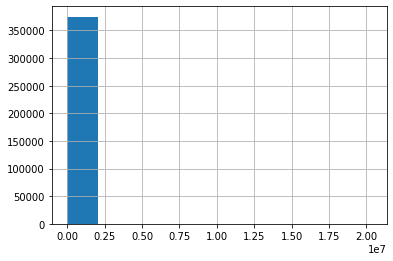

In [49]:

%matplotlib inline
kickstarter_2018['usd pledged'].hist();  # histograma de lo recaudado

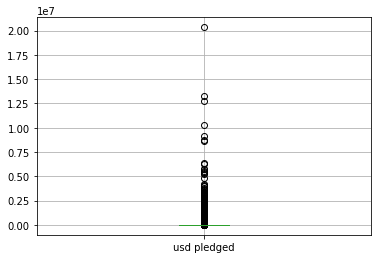

In [50]:
kickstarter_2018.boxplot(column='usd pledged');  # gráfico de boxplot de lo recaudado para observar outliers

"There are many rules of thumb for how to define an outlier but there is no silver bullet. One rule of thumb is that any data point that is three standard deviations away from the mean of the same data point for all observations."

In [51]:
outliers = kickstarter_2018[kickstarter_2018['usd pledged'] > (kickstarter_2018['usd pledged'].mean() + 
                                                            3 * kickstarter_2018['usd pledged'].std())]
# cálculo los ourliers, es decir outliers serán aquellos mayores a la media más la() desviación estándar *3) de lo recaudado
outliers

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000629643,ODIN: Android 'Smart' Projector to Carry in Yo...,Hardware,Technology,USD,2014-07-08,250000.00,2014-05-28 13:54:18,268192.00,successful,561,US,268192.00,268192.00,250000.00
1000725978,"Air Bonsai | Create your ""little star""",Product Design,Design,USD,2016-03-01,80000.00,2016-01-21 12:18:00,843743.00,successful,3784,US,843743.00,843743.00,80000.00
1001502333,Pimax: The World's First 8K VR Headset,Hardware,Technology,USD,2017-11-03,200000.00,2017-09-19 19:02:23,4236618.49,successful,5946,US,608194.00,4236618.49,200000.00
1003182869,RinseKit: The Revolutionary Portable Shower,Gadgets,Technology,USD,2016-06-03,30000.00,2016-05-04 19:27:57,396299.00,successful,2412,US,396299.00,396299.00,30000.00
1006008989,War for the Overworld,Video Games,Games,GBP,2013-01-03,150000.00,2012-11-29 19:11:23,211371.50,successful,8351,GB,338527.51,338589.87,240280.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994834878,KP Duffle - The Ultimate Travel Bag,Product Design,Design,USD,2016-03-04,15000.00,2016-01-19 17:00:36,624474.00,successful,3478,US,624474.00,624474.00,15000.00
995248054,LYFE - Set your plants free,Product Design,Design,USD,2016-07-01,80000.00,2016-06-01 18:53:37,328579.00,successful,1203,US,328579.00,328579.00,80000.00
995551135,Infinity: Battlescape,Video Games,Games,USD,2015-11-20,300000.00,2015-10-21 13:34:08,332620.81,successful,5828,US,332620.81,332620.81,300000.00


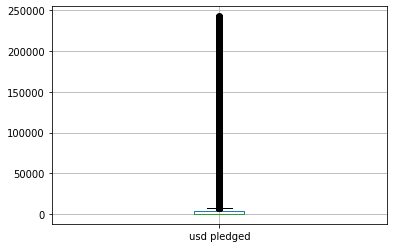

In [52]:
kickstarter_2018.drop(outliers.index).boxplot(column='usd pledged');  # gráfico de boxplot sin valores nulos para el valor recaudado

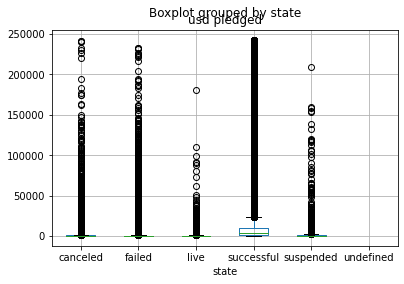

In [53]:
kickstarter_2018.drop(outliers.index).boxplot(column='usd pledged',by='state'); # gráfico de

Analizar outliers por categorías

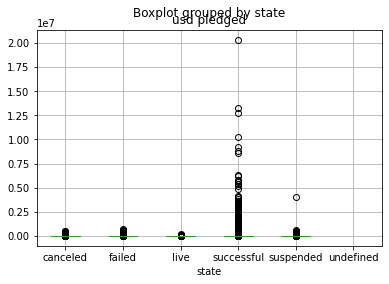

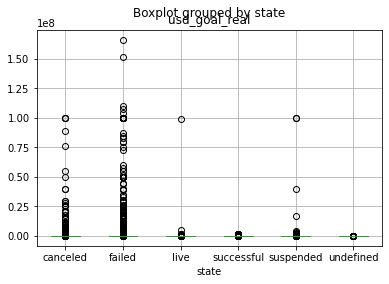

In [54]:
kickstarter_2018.boxplot(column='usd pledged',by='state');
kickstarter_2018.boxplot(column='usd_goal_real',by='state');

# **Ejercicio 6 para entrega final**

Calcular los valores atípicos de 'usd_goal_real' y graficar los boxplots, con y sin estos valores por categoría

In [43]:
import matplotlib.pyplot as plt
import seaborn as sbn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Text major ticklabel objects>)

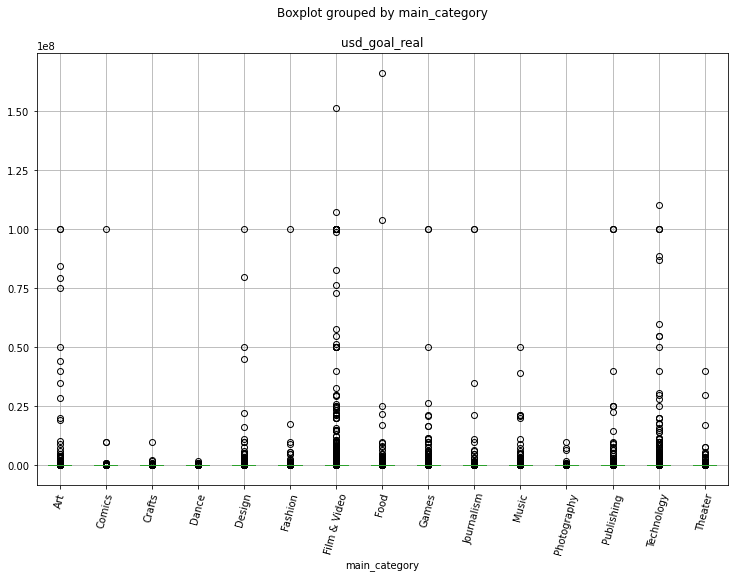

In [44]:
kickstarter_2018.boxplot(column='usd_goal_real', by='main_category',figsize=(12,8))
plt.xticks(rotation=75)


In [45]:
outliers_usd_goal_real = kickstarter_2018[kickstarter_2018.usd_goal_real > (kickstarter_2018.usd_goal_real.mean() + 
                                                            2 * kickstarter_2018.usd_goal_real.std())]
outliers_usd_goal_real                                                 

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1001904214,MKP - The Smart & Versatile Touch Screen Keybo...,Gadgets,Technology,GBP,2015-06-21,1700000.00,2015-04-22 22:40:38,970.00,canceled,4,GB,1444.02,1525.47,2673502.45
1005237669,The Old Soul of a Lion,Film & Video,Film & Video,USD,2014-10-14,3000000.00,2014-08-15 20:16:22,4.00,failed,2,US,4.00,4.00,3000000.00
1005364432,Code name: Interstellar (Canceled),Festivals,Theater,USD,2016-05-03,3000000.00,2016-03-04 04:30:08,0.00,canceled,0,US,0.00,0.00,3000000.00
1009207145,** GOLIATH **,Product Design,Design,CAD,2014-07-21,3850000.00,2014-06-21 22:34:21,285.00,failed,5,CA,263.41,264.67,3575408.62
1015466274,Genesis,Film & Video,Film & Video,EUR,2015-09-01,5000000.00,2015-07-07 21:14:52,0.00,failed,0,IT,0.00,0.00,5568982.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992624421,I don't know a comic book?,Comics,Comics,USD,2014-08-09,10000000.00,2014-07-10 06:11:48,10.00,failed,1,US,10.00,10.00,10000000.00
993969686,Albert Einstein Museum,Technology,Technology,USD,2014-12-20,50000000.00,2014-10-23 01:46:17,240.00,failed,8,US,240.00,240.00,50000000.00
994971752,Love Revolution 24,Country & Folk,Music,USD,2015-02-24,39023437.00,2015-01-31 09:05:34,5.00,failed,5,US,5.00,5.00,39023437.00


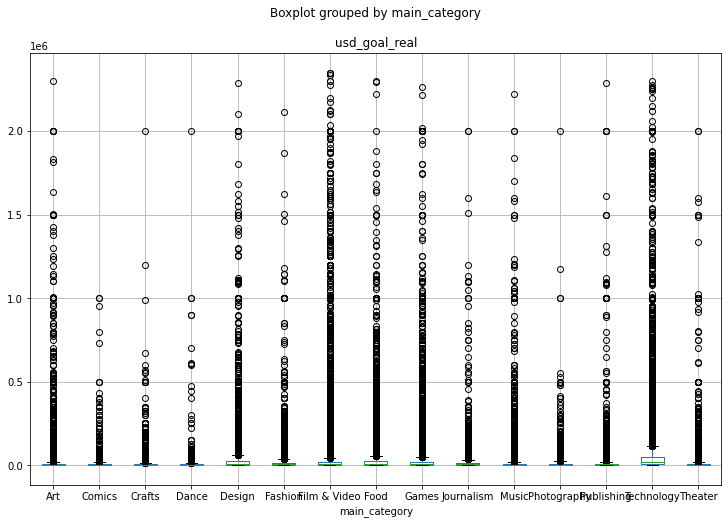

In [46]:
# elimino outliers
#kickstarter_2018.drop(outliers_usd_goal_real.index).boxplot(column='usd_goal_real')
kickstarter_2018.drop(outliers_usd_goal_real.index).boxplot(column='usd_goal_real', by='main_category',figsize=(12,8));  

## 2.7. Evaluar cómo comprimir los datos 
para su almacenamiento más eficiente.

En la actualidad, en las nubes el almacenamiento no suele ser problema sino la velocidad para leerlo que suele ser determinante a la hora de determinar el formato de almacenamiento.


## 2.8. Guardar el set de datos con un nombre informativo.
